In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='./Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./Data', train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./Data/MNIST/raw/train-images-idx3-ubyte.gz to ./Data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./Data/MNIST/raw/train-labels-idx1-ubyte.gz to ./Data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./Data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./Data/MNIST/raw



In [3]:
display(train_data)
print('-' * 50)
display(test_data)


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./Data
    Split: Train
    StandardTransform
Transform: ToTensor()

--------------------------------------------------


Dataset MNIST
    Number of datapoints: 10000
    Root location: ./Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [4]:
# create loader
BATCH_SIZE = 10

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

Label: [9 0 6 3 4 0 8 9 4 3]


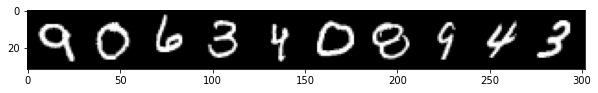

In [5]:
# View images in the database
# np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # widen the printed array

# Grab the first batch of 10 images
for images, labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
# print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
ima = make_grid(images, nrow=10)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(ima.numpy(), (1, 2, 0))); # because 0, 1, and 2 in the original image tensor represent RGB, horizontal axis, and vertical axis.

In [6]:
# define a convolutional model
# the figures are in 28x28 pixels

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)  # 1 input channels, 6 output channels, 3 of kernel size, and 1 pixel of stride
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)   # to fit 32x32 images with 3x3 filters 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5 * 5 * 16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

Here the number 5 in function "self.fc1 = nn.Linear(5 * 5 * 16, 120)" comes from convolutional layers and pooling layers. The original images in MNIST are 28x28.\
After the first convolutional layer its side becomes 28-2 = 26 (assume x and y sides are equal). Then pooling layer generate 26 / 2 = 13 pixels.\
After the second convolutional layer it becomes 13 - 2 = 11, then second pooling layer leads to 11 / 2 = 5.5.\
Thus it rounds down to 5 pixels per side.

In [7]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [9]:
# have a look at the number of parameters
count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


In [10]:
#check device
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
# fix random seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [12]:
# fix random seed for reproducibility
same_seeds(42)

device = get_device()
print(f'DEVICE: {device}')

# training parameters
n_epochs = 100               # number of training epoch
learning_rate = 0.0005       # learning rate

# the path where checkpoint saved
model_path = './MNIST_model.ckpt'

model = ConvolutionalNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

DEVICE: cuda


In [13]:
# Instantiate the model and load saved parameters if needed
print('deep_learinging_model_dropout0.ckpt' in os.listdir())
if 'deep_learinging_model_dropout0.ckpt' in os.listdir():
    model = ConvolutionalNetwork()
    model.load_state_dict(torch.load('MINST_model.ckpt'))
    model.eval()

NameError: ignored

In [14]:
import time
start_time = time.time()

n_epochs = 50

train_losses = []
test_losses = []
train_correct = []
test_correct = []
best_acc = 0
stale = 0
patience = 20

for i in range(n_epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        model.train()
        b+=1
        
        # Apply the model
        y_pred = model(X_train.to(device))
        loss = criterion(y_pred, y_train.to(device))
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train.to(device)).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  train batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item()/(10*b))
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            b += 1
            model.eval()

            # Apply the model
            y_val = model(X_test.to(device))

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test.to(device)).sum()
            
            loss = criterion(y_val, y_test.to(device))
            if b%500 == 0:
                print(f'epoch: {i:2}  val batch: {b:4} [{10*b:6}/10000]  loss: {loss.item():10.8f}  accuracy: {tst_corr.item()*100/(10*b):7.3f}%')
    
    test_losses.append(loss.item())
    test_correct.append(tst_corr.item()/(10*b))
    
    # if the model improves, save a checkpoint at this epoch
    val_acc = tst_corr.item()/(10*b)*100
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print('=====saving model with acc {:.3f}%====='.format(best_acc))
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stoppin")
            break
    print('-' * 100)
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  train batch: 1000 [ 10000/60000]  loss: 1.21976352  accuracy:  79.510%
epoch:  0  train batch: 2000 [ 20000/60000]  loss: 0.56562752  accuracy:  86.130%
epoch:  0  train batch: 3000 [ 30000/60000]  loss: 0.00819635  accuracy:  89.047%
epoch:  0  train batch: 4000 [ 40000/60000]  loss: 0.01109403  accuracy:  90.810%
epoch:  0  train batch: 5000 [ 50000/60000]  loss: 0.05745652  accuracy:  91.942%
epoch:  0  train batch: 6000 [ 60000/60000]  loss: 0.13694263  accuracy:  92.725%
epoch:  0  val batch:  500 [  5000/10000]  loss: 0.11135118  accuracy:  96.240%
epoch:  0  val batch: 1000 [ 10000/10000]  loss: 0.01155172  accuracy:  97.290%
=====saving model with acc 97.290%=====
----------------------------------------------------------------------------------------------------
epoch:  1  train batch: 1000 [ 10000/60000]  loss: 0.00184755  accuracy:  97.340%
epoch:  1  train batch: 2000 [ 20000/60000]  loss: 0.00397259  accuracy:  97.430%
epoch:  1  train batch: 3000 [ 30000/60000]

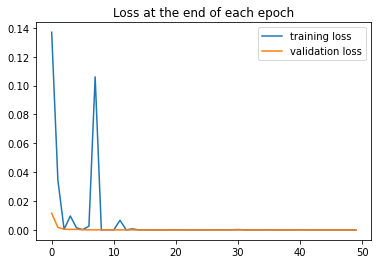

In [15]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [17]:
train_accuracy = []
valid_accuracy = []
for num in train_correct:
    train_accuracy.append(num )
for num in test_correct:
    valid_accuracy.append(num )

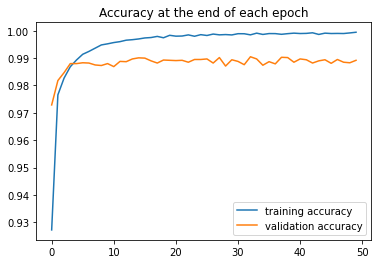

In [18]:
plt.plot(train_accuracy, label='training accuracy')
plt.plot(valid_accuracy, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [ ]:
# # Instantiate the model and load saved parameters
# model2 = ConvolutionalNetwork()
# model2.load_state_dict(torch.load('deep_learinging_model_dropout0.ckpt'))
# model2.eval()